In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors 
import tqdm
from scipy.interpolate import griddata, SmoothSphereBivariateSpline, Rbf


sys.path.append('../my_funcs/')
from pipeline_main import pipeline

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1234.69it/s]


21211.7281094472
Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9217.44it/s] 
/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/streamers/../my_funcs/pipeline_main.py:177: RuntimeWarning: invalid value encountered in sqrt
  σ_φ = np.sqrt(self.vφ2 - self.vφ**2)


Disk size: 41.3 au


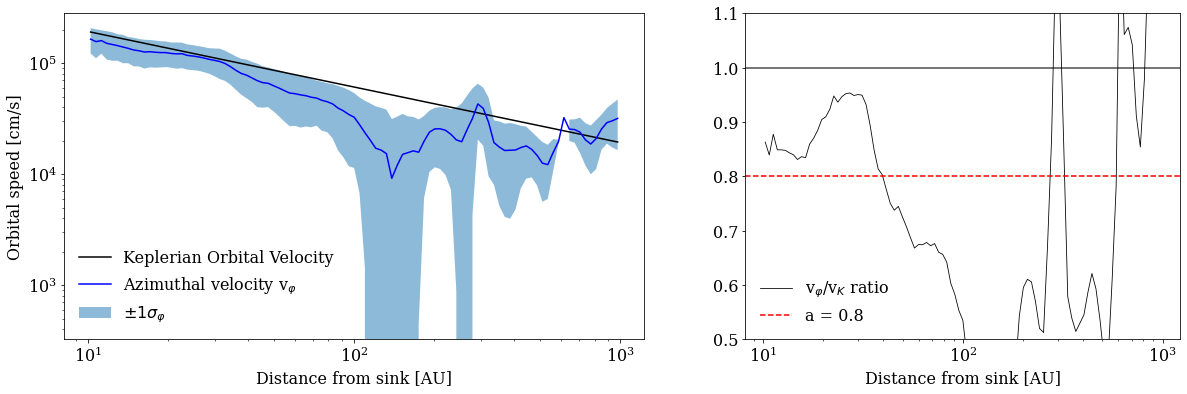

In [5]:
data = pipeline(snap = 710, run = 'my_core_13restart', sink_id = 13)
print(data.time)
data.recalc_L(verbose = 1); 
data.calc_disksize()

/tmp/ipykernel_4122376/1551799669.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(Lon, Lat, arr, cmap=plt.cm.jet)


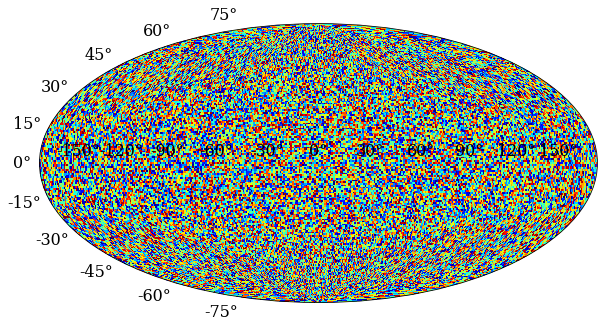

In [6]:
fig = plt.figure(figsize =(10, 10))
ax = fig.add_subplot(111, projection='hammer')
arr = np.random.rand(180, 360)

lon = np.linspace(-np.pi, np.pi,360)
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon , Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon, Lat, arr, cmap=plt.cm.jet)

####

# How to get the Hammer projection map:
### 1. for each point on the sphere within a certain shell R $\pm$ Δr calculate $\dot{M}$ 
### $$R=10\;,\quad \Delta r=0.5\;au$$
### 2. Convert xyz coordinates to longtitude and lattiude. 
### 3. Interpolate to given longitude and latitude
### 3. Create map as above 

### $$Longitude =\arctan\left(\frac{y}{x}\right)$$
### $$Latitude  = \arcsin\left(\frac{z}{R}\right)$$


In [7]:
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5588.17it/s]


In [8]:
shell_r = 50
Δ_r = 1
shell_r /= data.au_length; Δ_r /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_values = []
patch_cartcoor = []
longtitude = []
latitude = []
zoverR = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    R = np.linalg.norm(p.rel_xyz, axis = 0)
    idx = np.asarray(np.nonzero((R < shell_r + Δ_r) & (R > shell_r - Δ_r)))
    for lp in leafs: 
        extent = np.vstack((lp.position - 0.5 * lp.size, p.position + 0.5 * p.size)).T
        covered_idx = np.asarray(np.nonzero((p.xyz[0] > extent[0,0]) & ((p.xyz[0] < extent[0,1]))
                                 & (p.xyz[1] > extent[1,0]) & ((p.xyz[1] < extent[1,1]))
                                 & (p.xyz[2] > extent[2,0]) & ((p.xyz[2] < extent[2,1]))))

        to_remove_from_idx = np.all(idx.T[:, None, :] == covered_idx.T, axis = -1).any(axis = 1)
        idx = np.copy(idx.T[~to_remove_from_idx].T)
        if np.sum(idx) == 0:
            break
    if np.sum(idx) == 0:
            continue    

    new_xyz = p.trans_xyz[:, idx[0], idx[1], idx[2]].T
    new_R = np.linalg.norm(new_xyz, axis = 1)
    new_coor = p.cyl_r[:, idx[0], idx[1], idx[2]].T
    new_value = (p.var('d') * np.sum(p.vrel * (p.rel_xyz)/np.linalg.norm(p.rel_xyz, axis = 0), axis = 0))[idx[0], idx[1], idx[2]].T

    longtitude.extend(np.arctan2(new_xyz[:,1],  new_xyz[:,0]).tolist())
    latitude.extend((np.arcsin(new_xyz[:,2] / new_R)).tolist())    
    patch_values.extend(new_value.tolist())
    patch_cartcoor.extend(new_xyz.tolist())
    
patch_cartcoor = np.asarray(patch_cartcoor)
longtitude = np.asarray(longtitude)
latitude = np.asarray(latitude)
patch_values = np.asarray(patch_values)
sphere_coor = np.hstack((longtitude[:,None], latitude[:, None]))
values = patch_values * data.msun_mass / (data.au_length**2 * data.sn.cgs.yr)

100%|██████████| 4165/4165 [00:00<00:00, 5550.77it/s]


In [9]:
lon = np.linspace(-np.pi, np.pi, 360)
lat = np.linspace(-np.pi/2., np.pi/2., 180)
Lon , Lat = np.meshgrid(lon,lat)


proj_data = griddata(sphere_coor, values, xi = (Lon, Lat), method = 'linear')

In [10]:
np.sum(np.isnan(proj_data)), np.sum(~np.isnan(proj_data))

(1563, 63237)

In [11]:
np.nanmin(proj_data), np.nanmax(proj_data)

(-2.5440514880990016e-09, 1.2234528256067018e-09)

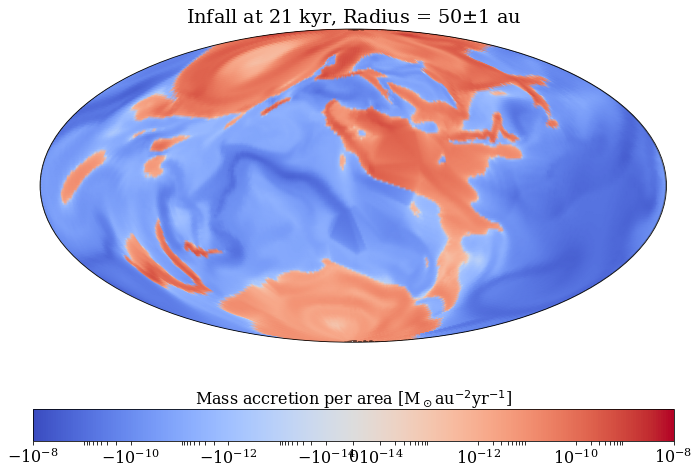

In [12]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='hammer')

range = 1e-8
ax.set_yticks([]); ax.set_xticks([])
im = ax.pcolormesh(Lon, Lat, proj_data, cmap='coolwarm', snap = True, norm=colors.SymLogNorm(linthresh=1e-14, linscale = 0.5, vmin = -range, vmax = range), shading = 'gouraud')
cbar = fig.colorbar(im, orientation='horizontal')
cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)
ax.set(title = f'Infall at {data.time/1e3 :2.0f} kyr, Radius = {shell_r * data.au_length:2.0f}$\pm${Δ_r*data.au_length:1.0f} au')
plt.tight_layout()

In [13]:
shell_r = 50
Δ_r = 1
shell_r /= data.au_length; Δ_r /= data.au_length

# VERY IMPORTANT NOTE: After the transformation the first axis is the height
patch_values = []
patch_cartcoor = []
longtitude = []
latitude = []
zoverR = []
for p in tqdm.tqdm(data.sn.patches):       
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    R = np.linalg.norm(p.rel_xyz, axis = 0)
    to_extract = (R < shell_r + Δ_r) & (R > shell_r - Δ_r)
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)

        to_extract *= covered_bool 

    new_xyz = p.trans_xyz[:, to_extract].T
    new_R = np.linalg.norm(new_xyz, axis = 1)
    new_value = (p.var('d') * np.sum(p.vrel * (p.rel_xyz)/np.linalg.norm(p.rel_xyz, axis = 0), axis = 0))[to_extract].T

    longtitude.extend(np.arctan2(new_xyz[:,1],  new_xyz[:,0]).tolist())
    latitude.extend((np.arcsin(new_xyz[:,2] / new_R)).tolist())    
    patch_values.extend(new_value.tolist())
    patch_cartcoor.extend(new_xyz.tolist())
    
patch_cartcoor = np.asarray(patch_cartcoor)
longtitude = np.asarray(longtitude)
latitude = np.asarray(latitude)
patch_values = np.asarray(patch_values)
sphere_coor = np.hstack((longtitude[:,None], latitude[:, None]))
values = patch_values * data.msun_mass / (data.au_length**2 * data.sn.cgs.yr)

100%|██████████| 4165/4165 [00:01<00:00, 2604.28it/s]


In [14]:
lon = np.linspace(-np.pi, np.pi, 360)
lat = np.linspace(-np.pi/2., np.pi/2., 180)
Lon , Lat = np.meshgrid(lon,lat)


proj_data = griddata(sphere_coor, values, xi = (Lon, Lat), method = 'linear')

In [15]:
np.sum(np.isnan(proj_data)), np.sum(~np.isnan(proj_data))

(1562, 63238)

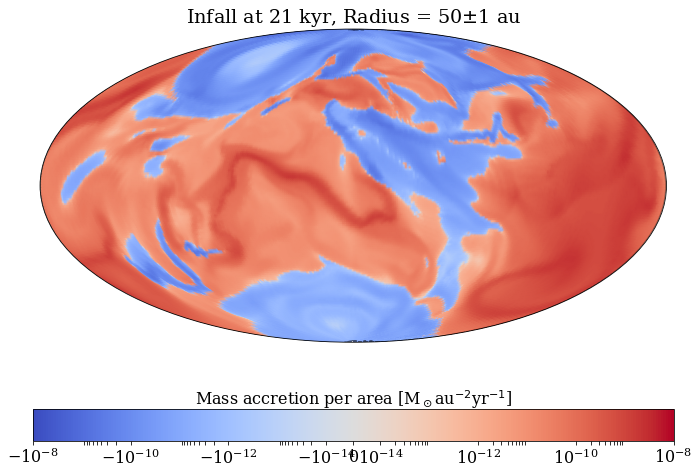

In [19]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='hammer')

range = 1e-8
ax.set_yticks([]); ax.set_xticks([])
im = ax.pcolormesh(Lon, Lat, -proj_data, cmap='coolwarm', snap = True, norm=colors.SymLogNorm(linthresh=1e-14, linscale = 0.5, vmin = -range, vmax = range), shading = 'gouraud')
cbar = fig.colorbar(im, orientation='horizontal')
cbar.set_label('Mass accretion per area [M$_\odot$au$^{-2}$yr$^{-1}$]', labelpad = -80, y = 2, rotation = 0, fontsize = 16)
ax.set(title = f'Infall at {data.time/1e3 :2.0f} kyr, Radius = {shell_r * data.au_length:2.0f}$\pm${Δ_r*data.au_length:1.0f} au')
plt.tight_layout()